<a href="https://colab.research.google.com/github/sanozzz/QuantBacktests/blob/main/MarketBreadthAnalyzer_(TV_Data).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ERROR:tvDatafeed:error while signin


Loaded symbols file: stock_list_25feb.csv with 1260 rows.
Loaded data from pickle file: /content/TV_Daily_Jan_01_2025.pkl with 903723 rows.
Data and symbols loaded successfully.
[2025-01-01 21:05:13] Starting Market Breadth metrics calculation.
[2025-01-01 21:05:23] Market Breadth metrics calculated for 1129 days.
Market Breadth report saved to /content/MarketBreadth_Jan_01_2025.csv.
Plot saved as /content/25CR+_MA14_chart.png
Plot saved as /content/50DMA_chart.png
Plot saved as /content/100CR+_MA14_chart.png
Plot saved as /content/200DMA_chart.png
Sent text message: Hello, group! Here is today's update
Sent chart: /content/25CR+_MA14_chart.png
Sent chart: /content/50DMA_chart.png
Sent chart: /content/100CR+_MA14_chart.png
Sent chart: /content/200DMA_chart.png


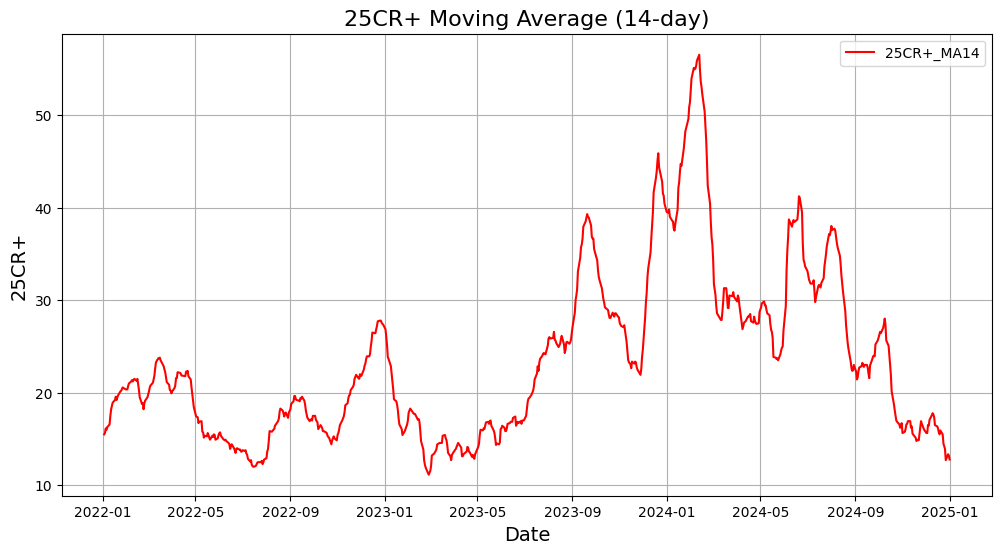

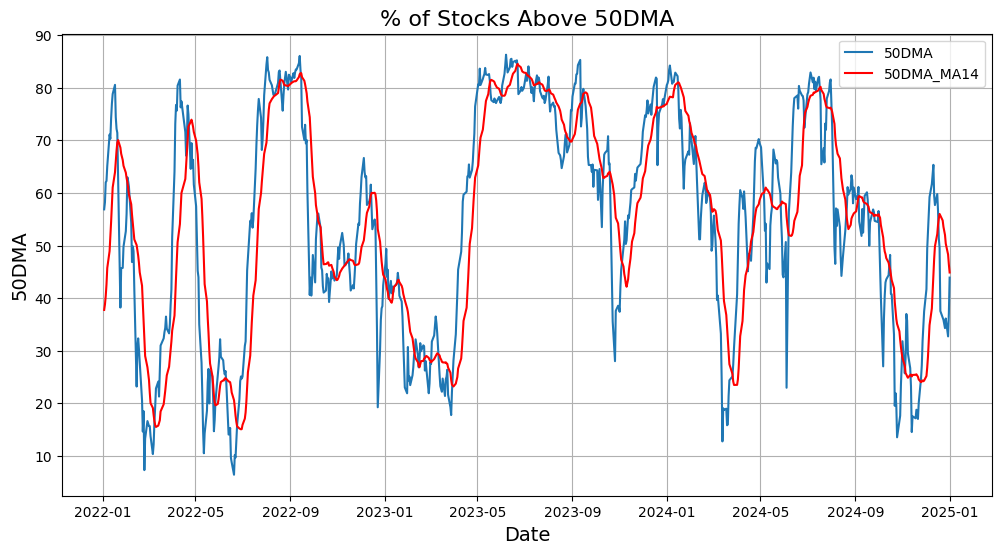

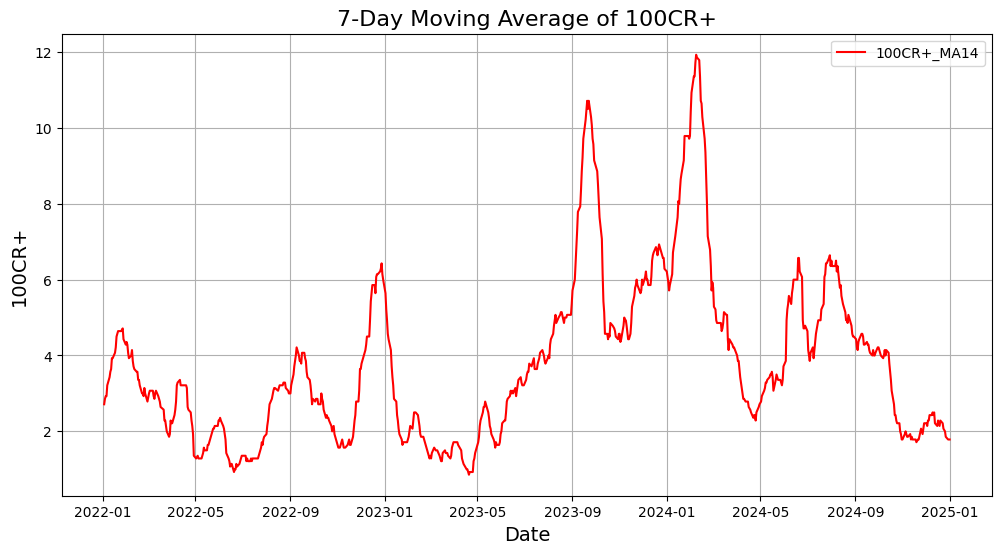

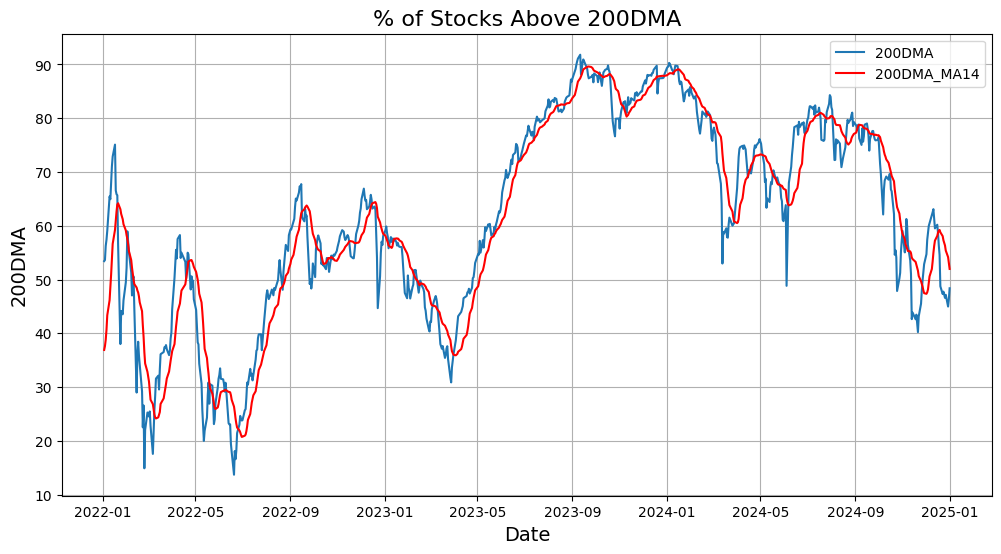

In [34]:
import os
import pandas as pd
import numpy as np
from tvDatafeed import TvDatafeed, Interval
from datetime import date, datetime
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import pytz
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import telegram
from telegram.error import TelegramError
from datetime import date
import datetime
from google.colab import userdata
import os
import datetime

from telegram.error import TelegramError

def log_with_timestamp(message):
    ist = pytz.timezone("Asia/Kolkata")
    # Use datetime.datetime.now(...) since we imported the module
    timestamp = datetime.datetime.now(ist).strftime('%Y-%m-%d %H:%M:%S')
    print(f"[{timestamp}] {message}")


class DataDownloader:
    def __init__(self, username, password, symbol_file, output_dir, max_workers=5):
        self.username = username
        self.password = password
        self.symbol_file = symbol_file
        self.output_dir = output_dir
        self.tv = TvDatafeed(username, password)
        self.symbols = None
        self.data = []
        self.failed_symbols = []
        self.max_workers = max_workers

    def load_symbols(self):
        """Load symbols from the given CSV file."""
        self.symbols = pd.read_csv(self.symbol_file)
        log_with_timestamp(f"Loaded {len(self.symbols)} symbols for download.")

    def _download_symbol_data(self, symbol, n_bars, max_retries=5):
        """Download data for a single symbol with retry and exponential backoff."""
        retries = 0
        while retries < max_retries:
            try:
                ts = self.tv.get_hist(symbol=symbol, interval=Interval.in_daily, n_bars=n_bars)
                log_with_timestamp(f"Downloaded: {symbol}")
                return ts, None
            except Exception as e:
                if "429 Too Many Requests" in str(e):
                    wait_time = 2 ** retries  # Exponential backoff
                    log_with_timestamp(f"Rate limit hit for {symbol}. Retrying in {wait_time} seconds...")
                    time.sleep(wait_time)
                    retries += 1
                else:
                    log_with_timestamp(f"Error downloading {symbol}: {e}")
                    return None, e
        log_with_timestamp(f"Max retries reached for {symbol}.")
        return None, "Max retries reached"

    def download_data(self, n_bars=800):
        """Download data concurrently for all symbols with rate limit handling."""
        log_with_timestamp(f"Starting data download for {len(self.symbols)} symbols...")

        with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            futures = {
                executor.submit(self._download_symbol_data, symbol, n_bars): symbol
                for symbol in self.symbols['Symbol']
            }

            for future in as_completed(futures):
                symbol = futures[future]
                try:
                    ts, error = future.result()
                    if ts is not None:
                        self.data.append(ts)
                    if error:
                        self.failed_symbols.append(symbol)
                except Exception as e:
                    self.failed_symbols.append(symbol)
                    log_with_timestamp(f"Unexpected error for {symbol}: {e}")

        log_with_timestamp(f"Download completed. {len(self.data)} symbols downloaded successfully.")
        log_with_timestamp(f"{len(self.failed_symbols)} symbols failed to download.")

    def retry_failed_downloads(self, n_bars=210):
        """Retry downloads for failed symbols."""
        if not self.failed_symbols:
            log_with_timestamp("No failed symbols to retry.")
            return

        log_with_timestamp(f"Retrying download for {len(self.failed_symbols)} failed symbols...")
        retries = []

        with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            futures = {
                executor.submit(self._download_symbol_data, symbol, n_bars): symbol
                for symbol in self.failed_symbols
            }

            for future in as_completed(futures):
                symbol = futures[future]
                try:
                    ts, error = future.result()
                    if ts is not None:
                        self.data.append(ts)
                    if error:
                        retries.append(symbol)
                except Exception as e:
                    retries.append(symbol)
                    log_with_timestamp(f"Unexpected error for {symbol}: {e}")

        self.failed_symbols = retries
        log_with_timestamp(f"Retry completed. {len(self.failed_symbols)} symbols still failed.")

    def save_data(self):
        """Save the downloaded data as both a pickle file and a CSV file."""
        today = date.today().strftime("%b_%d_%Y")
        pickle_path = os.path.join(self.output_dir, f"TV_Daily_{today}.pkl")
        csv_path = os.path.join(self.output_dir, f"TV_Daily_{today}.csv")

        if self.data:
            combined_data = pd.concat(self.data).reset_index(drop=False)
            combined_data = combined_data.rename(
                columns={
                    'datetime': 'DateTime', 'symbol': 'Symbol',
                    'open': 'Open', 'high': 'High',
                    'low': 'Low', 'close': 'Close',
                    'volume': 'Volume'
                }
            )
            # Save as pickle
            combined_data.to_pickle(pickle_path)
            log_with_timestamp(f"Data saved to pickle file: {pickle_path}")

            # Save as CSV
            combined_data.to_csv(csv_path, index=False)
            log_with_timestamp(f"Data saved to CSV file: {csv_path}")
        else:
            log_with_timestamp("No data to save.")

    def download_and_save(self):
        """Full workflow: load symbols, download data, retry failed, and save."""
        self.load_symbols()
        self.download_data()
        self.retry_failed_downloads()
        self.save_data()




class MarketAnalysis:
    def __init__(self, input_dir, output_dir):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.symbols = None
        self.data = None
        self.results = None

    def load_data(self, symbol_file, data_file):
        """Load symbol and data files."""
        try:
            # Load the symbols file (always CSV)
            self.symbols = pd.read_csv(os.path.join(self.input_dir, symbol_file))
            log_with_timestamp(f"Loaded symbols file: {symbol_file} with {len(self.symbols)} rows.")

            # Determine the data file format based on the extension
            data_path = os.path.join(self.input_dir, data_file)
            if data_file.endswith('.pkl'):
                self.data = pd.read_pickle(data_path)
                log_with_timestamp(f"Loaded data from pickle file: {data_file} with {len(self.data)} rows.")
            elif data_file.endswith('.csv'):
                self.data = pd.read_csv(data_path)
                log_with_timestamp(f"Loaded data from CSV file: {data_file} with {len(self.data)} rows.")
            else:
                log_with_timestamp(f"Unsupported file format: {data_file}")
                raise ValueError("Data file must be a .pkl or .csv file")

            log_with_timestamp("Data and symbols loaded successfully.")
        except Exception as e:
            log_with_timestamp(f"Error loading data: {e}")
            raise

    def filter_symbols(self, filter_key="FnO", filter_value=0):
        """Filter symbols based on a specific key and value."""
        try:
            self.symbols = self.symbols[self.symbols[filter_key] == filter_value]
            self.data = self.data[self.data['Symbol'].isin(self.symbols['Symbol'])]
            log_with_timestamp("Filtered symbols and data.")
        except Exception as e:
            log_with_timestamp(f"Error filtering symbols: {e}")
            raise

class MarketAnalysis:
    def __init__(self, input_dir, output_dir):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.symbols = None
        self.data = None
        self.results = None

    def load_data(self, symbol_file, data_file):
        """Load symbol and data files."""
        self.symbols = pd.read_csv(os.path.join(self.input_dir, symbol_file))
        print(f"Loaded symbols file: {symbol_file} with {len(self.symbols)} rows.")

        data_path = os.path.join(self.input_dir, data_file)
        if data_file.endswith('.pkl'):
            self.data = pd.read_pickle(data_path)
            print(f"Loaded data from pickle file: {data_file} with {len(self.data)} rows.")
        elif data_file.endswith('.csv'):
            self.data = pd.read_csv(data_path)
            print(f"Loaded data from CSV file: {data_file} with {len(self.data)} rows.")
        else:
            raise ValueError("Data file must be a .pkl or .csv file")

        print("Data and symbols loaded successfully.")

    def process_data(self):
        """
        1) Sort data by Symbol and DateTime.
        2) Compute 50DMA and 200DMA for each symbol.
        3) Group by daily date and compute market breadth metrics.
        4) Store the final DataFrame in self.results.
        """
        try:
            log_with_timestamp("Starting Market Breadth metrics calculation.")

            # ----------------------------
            #  STEP 1: Sort data
            # ----------------------------
            # Ensure data is in chronological order for each symbol
            self.data.sort_values(by=['Symbol', 'DateTime'], inplace=True)

            # ----------------------------
            #  STEP 2: Compute 50DMA & 200DMA
            # ----------------------------
            # For each symbol, compute rolling average over the Close price
            self.data['50DMA'] = self.data.groupby('Symbol')['Close'].transform(
                lambda x: x.rolling(window=50, min_periods=1).mean()
            )
            self.data['200DMA'] = self.data.groupby('Symbol')['Close'].transform(
                lambda x: x.rolling(window=200, min_periods=1).mean()
            )

            # ----------------------------
            #  STEP 3: Group by date
            # ----------------------------
            # Convert DateTime to just a date (year-month-day)
            self.data['Date'] = pd.to_datetime(self.data['DateTime']).dt.date
            daily_data = self.data.groupby('Date')

            metrics_list = []

            # ----------------------------
            #  STEP 4: Compute daily metrics
            # ----------------------------
            for current_date, group in daily_data:
                total = len(group)
                # 4%, 10%, 15% up
                pct_4_up = len(group[group['Close'] >= group['Open'] * 1.04])
                pct_10_up = len(group[group['Close'] >= group['Open'] * 1.10])
                pct_15_up = len(group[group['Close'] >= group['Open'] * 1.15])
                # 4%, 10%, 15% down
                pct_4_down = len(group[group['Close'] <= group['Open'] * 0.96])
                pct_10_down = len(group[group['Close'] <= group['Open'] * 0.90])
                pct_15_down = len(group[group['Close'] <= group['Open'] * 0.85])

                # Percentage of stocks above their 200DMA and 50DMA
                pct_above_200dma = 0
                pct_above_50dma = 0
                if total > 0:
                    pct_above_200dma = len(group[group['Close'] > group['200DMA']]) / total * 100
                    pct_above_50dma = len(group[group['Close'] > group['50DMA']]) / total * 100

                # 25CR+, 50CR+, 100CR+ as counts (number of symbols exceeding each threshold)
                count_25cr = len(group[group['Volume'] >= 25e6])
                count_50cr = len(group[group['Volume'] >= 50e6])
                count_100cr = len(group[group['Volume'] >= 100e6])

                # A/D ratio
                ad_ratio = (pct_4_up + pct_10_up + pct_15_up) / (pct_4_down + pct_10_down + pct_15_down + 1e-6)

                # Collect in metrics_list
                metrics_list.append({
                    "Date": current_date,
                    "Total": total,
                    "4PCT_UP": pct_4_up,
                    "10PCT_UP": pct_10_up,
                    "15PCT_UP": pct_15_up,
                    "4PCT_DOWN": pct_4_down,
                    "10PCT_DOWN": pct_10_down,
                    "15PCT_DOWN": pct_15_down,
                    "50DMA": pct_above_50dma,    # % of stocks above their 50-day MA
                    "200DMA": pct_above_200dma, # % of stocks above their 200-day MA
                    "25CR+": count_25cr,        # count of stocks with Volume >= 25e6
                    "50CR+": count_50cr,        # count of stocks with Volume >= 50e6
                    "100CR+": count_100cr,      # count of stocks with Volume >= 100e6
                    "ADRatio": ad_ratio
                })

            # ----------------------------
            #  STEP 5: Create final DataFrame
            # ----------------------------
            self.results = pd.DataFrame(metrics_list)
            if self.results.empty:
                log_with_timestamp("No daily metrics computed (empty results).")
                return

            # Example rolling columns on the daily aggregates:
            rolling_cols = [
                '200DMA', '50DMA',
                '4PCT_UP', '4PCT_DOWN',
                '10PCT_UP', '10PCT_DOWN',
                '25CR+', '50CR+', '100CR+'
            ]

            # Sort self.results by Date just in case
            self.results.sort_values(by='Date', inplace=True)

            for col in rolling_cols:
                if col in self.results.columns:
                    self.results[f"{col}_MA14"] = self.results[col].rolling(window=14).mean()
                else:
                    log_with_timestamp(f"Column '{col}' not in results. Skipping rolling average.")

            # Rolling A/D ratio
            if 'ADRatio' in self.results.columns:
                self.results['A/D_7MA'] = self.results['ADRatio'].rolling(window=7).mean()

            log_with_timestamp(f"Market Breadth metrics calculated for {len(self.results)} days.")
        except Exception as e:
            log_with_timestamp(f"Error processing data: {e}")
            raise


    def save_market_breadth_report(self):
        """Save the Market Breadth report."""
        today = date.today().strftime("%b_%d_%Y")
        file_path = os.path.join(self.output_dir, f"MarketBreadth_{today}.csv")
        if not self.results.empty:
            self.results.to_csv(file_path, index=False)
            print(f"Market Breadth report saved to {file_path}.")
        else:
            print("No Market Breadth metrics to save.")



class MarketBreadthPlot:
    def __init__(self, data):
        """
        Initialize the MarketBreadthPlot class.

        Parameters:
        - data (pd.DataFrame): DataFrame containing market breadth data with Date as a column.
        """
        self.data = data
        self.data['Date'] = pd.to_datetime(self.data['Date'])  # Ensure 'Date' is in datetime format



    def plot_metric(self, x_col='Date', y_col=None, ma_col=None,
                    title=None, ylabel=None, save_path=None):
        """
        Plot a metric (y_col) and/or a moving average (ma_col) against x_col.
        Turn off scientific notation for 25CR+ and 100CR+ by default.
        """
        plt.figure(figsize=(12, 6))

        # Plot the main metric if y_col is provided
        if y_col is not None:
            plt.plot(
                self.data[x_col],
                self.data[y_col],
                label=y_col,
                linewidth=1.5
            )

        # Plot the moving average if ma_col is provided
        if ma_col is not None:
            plt.plot(
                self.data[x_col],
                self.data[ma_col],
                label=ma_col,
                color='red',
                linewidth=1.5
            )

        # Add title, labels, and legend
        plt.title(title if title else "", fontsize=16)
        plt.ylabel(ylabel if ylabel else "", fontsize=14)
        plt.xlabel(x_col, fontsize=14)
        plt.legend()
        plt.grid(True)

        # -----------------------------
        # Disable scientific notation if it's 25CR+ or 100CR+
        # -----------------------------
        if ylabel in ["25CR+", "100CR+"]:
            # Option 1: Force plain style for y-axis
            plt.ticklabel_format(style="plain", axis="y")

            # Option 2 (alternative): Use a custom formatter for commas, etc.
            # plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

        # Save or show the plot
        if save_path:
            plt.savefig(save_path, bbox_inches='tight', format='png')
            print(f"Plot saved as {save_path}")
        #plt.show()



    def plot_all(self, save_dir=None, from_2022_only=True):
        """
        Generate and save all the required charts for market breadth data.

        Parameters:
        - save_dir (str): Directory to save the plots (optional).
        - from_2022_only (bool): If True, filters data to only show dates from 2022-01-01 onward.
        """
        import os
        import pandas as pd

        # Optionally filter data to dates >= 2022-01-01
        if from_2022_only:
            self.data = self.data[self.data["Date"] >= pd.to_datetime("2022-01-01")]

        # List of plot configs
        plots = [
            {
                # No y_col -> only the moving average
                "ma_col": "25CR+_MA14",
                "title": "25CR+ Moving Average (14-day)",
                "ylabel": "25CR+",
                "save_name": "25CR+_MA14_chart.png"
            },
            {
                # Has both metric and its moving average
                "y_col": "50DMA",
                "ma_col": "50DMA_MA14",
                "title": "% of Stocks Above 50DMA",
                "ylabel": "50DMA",
                "save_name": "50DMA_chart.png"
            },
            {
                # No y_col -> only the moving average
                "ma_col": "100CR+_MA14",
                "title": "7-Day Moving Average of 100CR+",
                "ylabel": "100CR+",
                "save_name": "100CR+_MA14_chart.png"
            },
            {
                "y_col": "200DMA",
                "ma_col": "200DMA_MA14",
                "title": "% of Stocks Above 200DMA",
                "ylabel": "200DMA",
                "save_name": "200DMA_chart.png"
            }
        ]

        # Generate plots
        for plot in plots:
            save_path = None
            if save_dir:
                save_path = os.path.join(save_dir, plot["save_name"])

            self.plot_metric(
                x_col="Date",
                y_col=plot.get("y_col"),      # might be None for 25CR+ & 100CR+
                ma_col=plot.get("ma_col"),    # the moving average column
                title=plot["title"],
                ylabel=plot["ylabel"],
                save_path=save_path
            )




class TelegramChartSender:
    """
    Encapsulates the logic for sending text messages and chart images to a Telegram chat or channel.
    """

    def __init__(self, bot_token: str, chat_id: str):
        """
        Initializes the Telegram bot with the given token and sets the chat/channel ID.

        Args:
            bot_token (str): Token provided by BotFather, e.g. "123456:ABC-DEF1234ghIkl-zyx57W2v1u123ew11"
            chat_id (str or int): Numeric chat ID (e.g., -1001234567890 for groups) or channel username (e.g., "@my_channel")
        """
        self.bot_token = bot_token
        self.chat_id = chat_id
        self.bot = telegram.Bot(token=self.bot_token)

    def send_text_update(self, custom_text: str = None):
        """
        Sends a text message to the configured Telegram chat/channel.
        If no custom_text is provided, sends a default "Here is today's update @ <timestamp>" message.

        Args:
            custom_text (str): Optional text to send. If None, uses a default with a timestamp.
        """
        if not custom_text:
            # Generate a default message with timestamp
            timestamp_str = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            custom_text = f"Here is today's update @ {timestamp_str}"

        try:
            self.bot.send_message(chat_id=self.chat_id, text=custom_text)
            print(f"Sent text message: {custom_text}")
        except TelegramError as e:
            print(f"Error sending text message: {e}")

    def send_charts(self, file_paths: list):
        """
        Sends a list of .png (or other image) files to the configured Telegram chat/channel.

        Args:
            file_paths (list): List of file paths (strings) to .png images.
        """
        for file_path in file_paths:
            if os.path.exists(file_path):
                try:
                    with open(file_path, 'rb') as chart_file:
                        # Send as a photo
                        self.bot.send_photo(chat_id=self.chat_id, photo=chart_file)
                    print(f"Sent chart: {file_path}")
                except TelegramError as e:
                    print(f"Error sending {file_path}: {e}")
            else:
                print(f"File not found: {file_path}")

    def send_daily_update(self, file_paths: list, custom_text: str = None):
        """
        Sends a text update (with a timestamp or custom text), then sends any charts provided.

        Args:
            file_paths (list): List of file paths (strings) to .png images.
            custom_text (str): Optional message text to send before charts.
        """
        # First send a text update (timestamp or custom)
        self.send_text_update(custom_text=custom_text)
        # Then send the charts
        self.send_charts(file_paths)




if __name__ == "__main__":
    username = 'nileshiit'
    password = 'Hari@123om'
    symbol_file = '/content/stock_list_25feb.csv'
    output_dir = '/content'


    token = userdata.get('TELEGRAM_BOT_TOKEN')
    chat_id = userdata.get('TELEGRAM_CHAT_ID')
    group_id = userdata.get('TELEGRAM_GROUP_ID')
    # Ensure save_dir exists
    os.makedirs(output_dir, exist_ok=True)

    # Data Download
    downloader = DataDownloader(username, password, symbol_file, output_dir, max_workers=5)
    #downloader.download_and_save()


    # Market Analysis
    analysis = MarketAnalysis(output_dir, output_dir)
    analysis.load_data("stock_list_25feb.csv", f"{output_dir}/TV_Daily_{date.today().strftime('%b_%d_%Y')}.pkl")

    # Process data and save Market Breadth
    analysis.process_data()
    analysis.save_market_breadth_report()


    # Load the generated CSV file
    today = date.today().strftime("%b_%d_%Y")
    # Instead of loading TV_Daily_{today}.csv:
    csv_file_path = os.path.join(output_dir, f"MarketBreadth_{today}.csv")

    # Now this CSV contains columns like Date, 50DMA, 200DMA, etc.
    market_data = pd.read_csv(csv_file_path)

    # Then pass it to MarketBreadthPlot
    plotter = MarketBreadthPlot(market_data)
    plotter.plot_all(save_dir=output_dir)

    # Replace with the correct chat ID or channel username
    TELEGRAM_CHAT_ID = TELEGRAM_CHAT_ID  # or "@my_channel"


    # Example chart file paths
    chart_paths = [
        "/content/25CR+_MA14_chart.png",
        "/content/50DMA_chart.png",
        "/content/100CR+_MA14_chart.png",
        "/content/200DMA_chart.png"
    ]

    custom_text = f"Hello, group! Here is today's update"

    # Initialize your chart sender with the bot token and group ID
    sender = TelegramChartSender(bot_token=TELEGRAM_BOT_TOKEN, chat_id=GROUP_ID)

    # 1) Send a text update (with the timestamped message)
    sender.send_text_update(custom_text=custom_text)

    # 2) Send the charts
    sender.send_charts(chart_paths)







In [ ]:
# url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
# !curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
# url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
# !curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
# import talib

# !pip install mypy_extensions schedule kiteconnect gspread_pandas dateparser
# !pip install python-telegram-bot==13.14
